In [6]:
import pandas as pd
import os
import sys
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
sys.path.insert(1, '../src/')
from CNN_classifier_model import CNNClassifier, train_model, evaluate_model
from config import raw_data_path, univariate_data_path, processed_data_path, results_path
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report
)


# Load the saved predictions


file_name = 'results_FCMAE_resnet_SGD.csv'

path = os.path.join(results_path, file_name)
df = pd.read_csv(path)

def extract_base_record_id(window_id):
    return re.sub(r"-chan\d+-\d+$", "", window_id)
    df["base_record_id"] = df["window_id"].apply(extract_base_record_id)


In [7]:
# '''MAJORITY VOTE OVER ALL RUNS'''
# # Extract base record_id (remove '-chanX-window')
# def extract_base_record_id(window_id):
#     return re.sub(r"-chan\d+-\d+$", "", window_id)

# df["base_record_id"] = df["window_id"].apply(extract_base_record_id)

# # Determine number of runs
# run_indices = sorted(set(int(col.replace("pred_label", "")) for col in df.columns if col.startswith("pred_label")))

# # Store per-run metrics
# metrics_list = []

# for i in run_indices:
#     label_col = f"pred_label{i}"
#     prob_col = f"pred_prob{i}"

#     # Group by base_record_id and aggregate per patient
#     aggregated = df.groupby("base_record_id").agg({
#         label_col: lambda x: np.bincount(x).argmax(),  # Majority vote
#         "target": lambda x: x.iloc[0],                 # Assume same target per patient
#         prob_col: "mean"
#     }).reset_index()

#     y_true = aggregated["target"].values
#     y_pred = aggregated[label_col].values
#     y_probs = aggregated[prob_col].values

#     try:
#         auc = roc_auc_score(y_true, y_probs)
#     except ValueError:
#         auc = np.nan

#     try:
#         ap = average_precision_score(y_true, y_probs)
#     except ValueError:
#         ap = np.nan

#     metrics_list.append({
#         "accuracy": accuracy_score(y_true, y_pred),
#         "precision": precision_score(y_true, y_pred, zero_division=0),
#         "recall": recall_score(y_true, y_pred, zero_division=0),
#         "f1": f1_score(y_true, y_pred, zero_division=0),
#         "auc": auc,
#         "ap": ap
#     })

# # Convert to DataFrame and compute mean + std
# metrics_df = pd.DataFrame(metrics_list)
# mean_metrics = metrics_df.mean()
# std_metrics = metrics_df.std()

# print(f"\n📊 Aggregated Metrics over {len(run_indices)} Runs:\n")
# for metric in mean_metrics.index:
#     print(f"{metric.capitalize():<10}: {mean_metrics[metric]:.4f} ± {std_metrics[metric]:.4f}")

# # Confusion matrix from best run (optional — pick run 1 or the best AP run)
# best_run_idx = int(metrics_df["ap"].idxmax()) + 1
# label_col = f"pred_label{best_run_idx}"
# aggregated = df.groupby("base_record_id").agg({
#     label_col: lambda x: np.bincount(x).argmax(),
#     "target": lambda x: x.iloc[0],
# }).reset_index()


# y_pred = aggregated[label_col].values
# y_true = aggregated["target"].values

# cm = confusion_matrix(y_true, y_pred)
# print("\n🧩 Confusion Matrix (Best Run):")
# print(cm)
# print("\n📃 Classification Report (Best Run):")
# print(classification_report(y_true, y_pred, digits=4))

# # Plot confusion matrix
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix (Best Run)')
# plt.show()


📊 Aggregated Soft Voting Metrics over 5 Runs:

Accuracy  : 0.4188 ± 0.0815
Precision : 0.2361 ± 0.3242
Recall    : 0.2000 ± 0.3260
F1        : 0.2053 ± 0.3054
Auc       : 0.5908 ± 0.0331
Ap        : 0.7287 ± 0.0432

🧩 Confusion Matrix (Best Run - Soft Voting):
[[12  0]
 [19  1]]

📃 Classification Report (Best Run - Soft Voting):
              precision    recall  f1-score   support

           0     0.3871    1.0000    0.5581        12
           1     1.0000    0.0500    0.0952        20

    accuracy                         0.4062        32
   macro avg     0.6935    0.5250    0.3267        32
weighted avg     0.7702    0.4062    0.2688        32



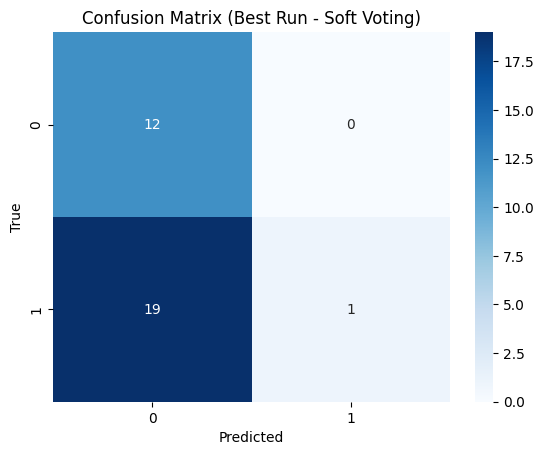

In [8]:
'''SOFT VOTING OVER ALL RUNS'''

import numpy as np
import pandas as pd
import re
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# Sigmoid function to convert logits to probabilities
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Extract base_record_id
df["base_record_id"] = df["window_id"].apply(lambda x: re.sub(r"-chan\d+-\d+$", "", x))

# Identify runs
run_indices = sorted(set(int(col.replace("pred_label", "")) for col in df.columns if col.startswith("pred_label")))

metrics_list = []
aggregated_probs_per_run = []

for i in run_indices:
    prob_col = f"pred_prob{i}"

    # Convert logits to probabilities
    df[prob_col] = sigmoid(df[prob_col])

    # Aggregate per patient using mean of probabilities (soft vote)
    aggregated = df.groupby("base_record_id").agg({
        prob_col: "mean",
        "target": lambda x: x.iloc[0]
    }).reset_index()

    # Save for averaging later
    aggregated_probs_per_run.append(aggregated.set_index("base_record_id")[prob_col])

    # Threshold to get labels
    aggregated[f"pred_label{i}"] = (aggregated[prob_col] >= 0.5).astype(int)

    # Evaluate this run
    y_true = aggregated["target"].values
    y_pred = aggregated[f"pred_label{i}"].values
    y_prob = aggregated[prob_col].values

    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = np.nan
    try:
        ap = average_precision_score(y_true, y_prob)
    except ValueError:
        ap = np.nan

    metrics_list.append({
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "auc": auc,
        "ap": ap
    })

# Metrics summary
metrics_df = pd.DataFrame(metrics_list)
mean_metrics = metrics_df.mean()
std_metrics = metrics_df.std()

print(f"\n📊 Aggregated Soft Voting Metrics over {len(run_indices)} Runs:\n")
for metric in mean_metrics.index:
    print(f"{metric.capitalize():<10}: {mean_metrics[metric]:.4f} ± {std_metrics[metric]:.4f}")

# 🎯 Final Soft Voting Across Runs (Average per-patient probs over all runs)
mean_probs = pd.concat(aggregated_probs_per_run, axis=1).mean(axis=1)
final_targets = df.groupby("base_record_id")["target"].first()

final_df = pd.DataFrame({
    "pred_prob": mean_probs,
    "target": final_targets
})
final_df["pred_label"] = (final_df["pred_prob"] >= 0.5).astype(int)

# # 📉 Confusion Matrix for Final Soft Voting Result
# y_true = final_df["target"].values
# y_pred = final_df["pred_label"].values


# Group by patient to aggregate (should already be soft-voted over windows within best_pred_prob)
best_agg = df.groupby("base_record_id").agg({
    "best_pred_prob": "mean",  # already averaged over windows
    "best_pred_label": lambda x: x.mode().iloc[0],  # should all be the same if label was decided per patient
    "target": lambda x: x.iloc[0]  # single target per patient
}).reset_index()

# Confusion matrix using best run’s per-patient predictions
y_true = best_agg["target"].values
y_pred = best_agg["best_pred_label"].values

cm = confusion_matrix(y_true, y_pred)
print("\n🧩 Confusion Matrix (Best Run - Soft Voting):")
print(cm)
print("\n📃 Classification Report (Best Run - Soft Voting):")
print(classification_report(y_true, y_pred, digits=4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Best Run - Soft Voting)')
plt.show()

# cm = confusion_matrix(y_true, y_pred)
# print("\n🧩 Confusion Matrix (Soft Voting):")
# print(cm)
# print("\n📃 Classification Report (Soft Voting):")
# print(classification_report(y_true, y_pred, digits=4))

# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix (Soft Voting)')
# plt.show()



🎯 Best Run (based on AP) Metrics:
Number of patients: 32
Accuracy:  0.4062
Precision: 1.0000
Recall:    0.0500
F1-score:  0.0952
AUC:       0.6333333333333333
AP Score:  0.7352835017328427

📊 Confusion Matrix:
[[12  0]
 [19  1]]

📃 Classification Report:
              precision    recall  f1-score   support

           0     0.3871    1.0000    0.5581        12
           1     1.0000    0.0500    0.0952        20

    accuracy                         0.4062        32
   macro avg     0.6935    0.5250    0.3267        32
weighted avg     0.7702    0.4062    0.2688        32



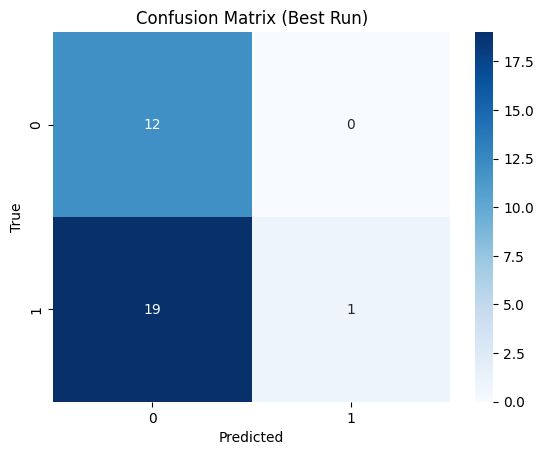

In [9]:
'''MAJORITY VOTING'''


# Aggregate by patient
aggregated = df.groupby("base_record_id").agg({
    "best_pred_label": lambda x: np.bincount(x).argmax(),  # Majority vote
    "target": lambda x: x.iloc[0],                         # Same target per patient
    "best_pred_prob": "mean"                               # Mean probability
}).reset_index()

# Extract final values
y_true = aggregated["target"].values
y_pred = aggregated["best_pred_label"].values
y_probs = aggregated["best_pred_prob"].values

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
try:
    auc = roc_auc_score(y_true, y_probs)
except ValueError:
    auc = "Undefined (only one class present)"
try:
    ap = average_precision_score(y_true, y_probs)
except ValueError:
    ap = "Undefined (only one class present)"
cm = confusion_matrix(y_true, y_pred)

# Print results
print("\n🎯 Best Run (based on AP) Metrics:")
print(f"Number of patients: {len(aggregated)}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC:       {auc}")
print(f"AP Score:  {ap}")

print("\n📊 Confusion Matrix:")
print(cm)

print("\n📃 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Best Run)')
plt.show()


Patients:   32
Accuracy:   0.6250
Precision:  0.6250
Recall:     1.0000
F1-score:   0.7692
AUC:        0.625
AP Score:   0.7726061578703967

📊 Confusion Matrix:
[[ 0 12]
 [ 0 20]]

📃 Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        12
           1     0.6250    1.0000    0.7692        20

    accuracy                         0.6250        32
   macro avg     0.3125    0.5000    0.3846        32
weighted avg     0.3906    0.6250    0.4808        32



/scratch-local/nwertheim.11778840/ipykernel_3978225/745036883.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[prob_cols] = df[prob_cols].applymap(sigmoid)
/home/nwertheim/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nwertheim/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nwertheim/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined 

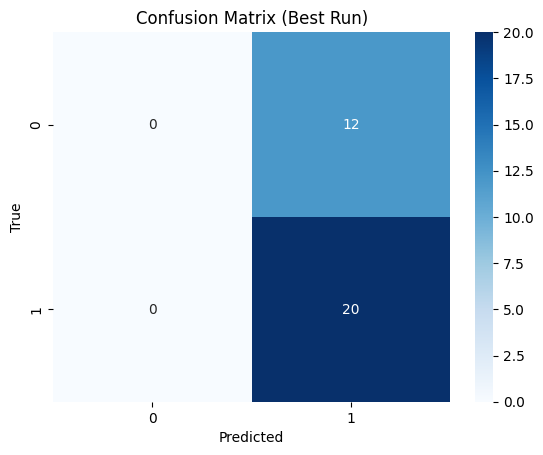

In [10]:
'''SOFT VOTING'''
# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Convert all pred_prob columns (except 'best_pred_prob' if already in [0,1]) to probabilities
prob_cols = [col for col in df.columns if "pred_prob" in col and col != "best_pred_prob"]
df[prob_cols] = df[prob_cols].applymap(sigmoid)
df["base_record_id"] = df["window_id"].apply(extract_base_record_id)
# Take the mean of all predicted probabilities per record
soft_vote_probs = df.groupby("base_record_id")[prob_cols].mean().mean(axis=1)

# Determine final label by thresholding mean probability
soft_vote_labels = (soft_vote_probs >= 0.5).astype(int)

# Target: assume same per record
true_targets = df.groupby("base_record_id")["target"].first()

# Final dataframe for evaluation
aggregated_soft = pd.DataFrame({
    "pred_prob": soft_vote_probs,
    "pred_label": soft_vote_labels,
    "target": true_targets
}).reset_index()

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)

y_true = aggregated_soft["target"]
y_pred = aggregated_soft["pred_label"]
y_prob = aggregated_soft["pred_prob"]

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
try:
    auc = roc_auc_score(y_true, y_prob)
except ValueError:
    auc = "Undefined"
try:
    ap = average_precision_score(y_true, y_prob)
except ValueError:
    ap = "Undefined"

# Output
print(f"Patients:   {len(aggregated_soft)}")
print(f"Accuracy:   {accuracy:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1-score:   {f1:.4f}")
print(f"AUC:        {auc}")
print(f"AP Score:   {ap}")
cm = confusion_matrix(y_true, y_pred)
print("\n📊 Confusion Matrix:")
print(cm)

print("\n📃 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Best Run)')
plt.show()
